# Named Entity Recognition

### Dự đoán named entities trong cơ sở dữ liệu GMB(Groningen Meaning Bank)

Sử dụng Sequence Tagging với mô hình LSTM-CRF để trích xuất tên các thực thể trong văn bản
nhãn các thực thể được mã hóa sử dụng các ký hiệu BIO, trong đó mỗi nhãn thực thể được gán với ký hiệu B hoặc I. B- ký hiệu là bắt đầu (begining) và I- là bên trong (inside) một thực thể. Các ký hiệu này dùng để xác định các thực thể có nhiều từ, ví dụ với câu :"World War II", các nhãn là:(B-eve, I-eve, I-eve). Các từ khác, không thuộc thực thể được gán nhãn là O.
Tag | Label meaning | Example Given
------------ | ------------- |
geo | Geographical Entity | London
org | Organization | ONU
per | Person | Bush
gpe | Geopolitical Entity | British
tim | Time indicator | Wednesday
art | Artifact | Chrysler
eve | Event | Christmas
nat | Natural Phenomenon | Hurricane
O | No-Label | the

Chúng ta sẽ thực hiện:
- Preprocess text data for NLP
- Build and train a Bi-directional LSTM-CRF model using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on your own sentences!
Mô hình:
<img src="https://raw.githubusercontent.com/floydhub/named-entity-recognition-template/master/images/bilstm-crf.png" width="400" height="400" align="center"/>

In [2]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Các tham số

In [3]:
# Hyperparams if GPU is available
if tf.config.list_physical_devices('GPU'):
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector


# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

## Data

In [4]:
# đọc dữ liệu csv với pandas
data = pd.read_csv("/content/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

<ipython-input-4-ac20cace3430>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


Number of sentences:  47959
Number of words in the dataset:  35177
Tags: ['I-per', 'I-tim', 'I-geo', 'O', 'I-nat', 'B-org', 'I-org', 'B-eve', 'B-tim', 'B-art', 'I-gpe', 'B-gpe', 'I-art', 'B-nat', 'B-geo', 'B-per', 'I-eve']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


<ipython-input-5-4eb213779afa>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


As you can see from the output Cell above, each sentence in the dataset is represented as a list of tuple: [`(Token_1, PoS_1, Tag_1)`, ..., `(Token_n, PoS_n, Tag_n)`].

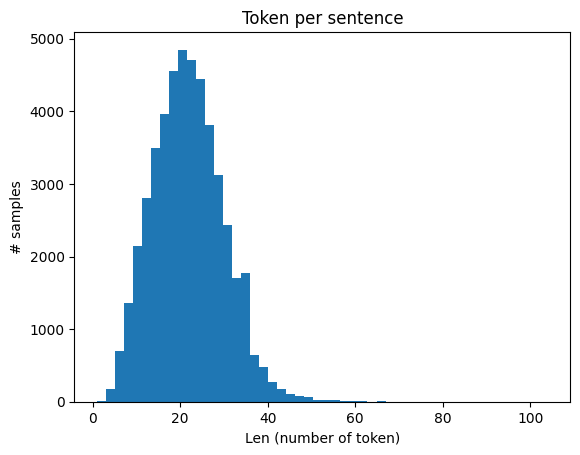

In [6]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Tiền xử lý dữ liệu

-Sử dụng từ điển `word2idx` để chuyển 1 từ thành 1 số nguyên ID và tương tự từ điển `tag2idx` cho nhãn
- Padding tất cả các câu có cùng số từ `MAX_LEN`

In [7]:
!pip install keras

In [8]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences
# Biểu diễn vector cho các câu, mỗi từ --> 1 số nguyên, câu => vector
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding các câu về cùng chiều dài MAXLEN
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# tương tự với các nhãn (Tag/Label)
# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 21179
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 15
Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [15722 17559 26009 32503 13045 17545 30905 31707  2975 22376 33539 21524
 11611  1758  2085 22376 30705 17559 13249 29096 21327 17819 22612 28031
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0

In [9]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-jgoch19n
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-jgoch19n
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [10]:
!pip install tf2crf

In [14]:
from keras.models import Model
from keras import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# from keras_contrib.layers import CRF

import tensorflow as tf



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


AttributeError: Exception encountered when calling CRF.call().

[1mmodule 'keras.backend' has no attribute 'dot'[0m

Arguments received by CRF.call():
  • X=tf.Tensor(shape=(47959, 75, 50), dtype=float32)
  • mask=tf.Tensor(shape=(47959, 75), dtype=bool)

In [31]:
from __future__ import absolute_import
from __future__ import division

import warnings

from keras import backend as K
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.layers import Layer
from keras.layers import InputSpec
import tensorflow as tf
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_marginal_accuracy
from keras_contrib.metrics import crf_viterbi_accuracy
from keras_contrib.utils.test_utils import to_tuple


class CRF(Layer):
    """An implementation of linear chain conditional random field (CRF).

    An linear chain CRF is defined to maximize the following likelihood function:

    $$ L(W, U, b; y_1, ..., y_n) := \frac{1}{Z}
    \sum_{y_1, ..., y_n} \exp(-a_1' y_1 - a_n' y_n
        - \sum_{k=1^n}((f(x_k' W + b) y_k) + y_1' U y_2)), $$

    where:
        $Z$: normalization constant
        $x_k, y_k$:  inputs and outputs

    This implementation has two modes for optimization:
    1. (`join mode`) optimized by maximizing join likelihood,
    which is optimal in theory of statistics.
       Note that in this case, CRF must be the output/last layer.
    2. (`marginal mode`) return marginal probabilities on each time
    step and optimized via composition
       likelihood (product of marginal likelihood), i.e.,
       using `categorical_crossentropy` loss.
       Note that in this case, CRF can be either the last layer or an
       intermediate layer (though not explored).

    For prediction (test phrase), one can choose either Viterbi
    best path (class indices) or marginal
    probabilities if probabilities are needed.
    However, if one chooses *join mode* for training,
    Viterbi output is typically better than marginal output,
    but the marginal output will still perform
    reasonably close, while if *marginal mode* is used for training,
    marginal output usually performs
    much better. The default behavior and `metrics.crf_accuracy`
    is set according to this observation.

    In addition, this implementation supports masking and accepts either
    onehot or sparse target.

    If you open a issue or a pull request about CRF, please
    add 'cc @lzfelix' to notify Luiz Felix.


    # Examples

    ```python
        from keras_contrib.layers import CRF
        from keras_contrib.losses import crf_loss
        from keras_contrib.metrics import crf_viterbi_accuracy

        model = Sequential()
        model.add(Embedding(3001, 300, mask_zero=True)(X)

        # use learn_mode = 'join', test_mode = 'viterbi',
        # sparse_target = True (label indice output)
        crf = CRF(10, sparse_target=True)
        model.add(crf)

        # crf_accuracy is default to Viterbi acc if using join-mode (default).
        # One can add crf.marginal_acc if interested, but may slow down learning
        model.compile('adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])

        # y must be label indices (with shape 1 at dim 3) here,
        # since `sparse_target=True`
        model.fit(x, y)

        # prediction give onehot representation of Viterbi best path
        y_hat = model.predict(x_test)
    ```

    The following snippet shows how to load a persisted
    model that uses the CRF layer:

    ```python
        from keras.models import load_model
        from keras_contrib.losses import import crf_loss
        from keras_contrib.metrics import crf_viterbi_accuracy

        custom_objects={'CRF': CRF,
                        'crf_loss': crf_loss,
                        'crf_viterbi_accuracy': crf_viterbi_accuracy}

        loaded_model = load_model('<path_to_model>',
                                  custom_objects=custom_objects)
    ```

    # Arguments
        units: Positive integer, dimensionality of the output space.
        learn_mode: Either 'join' or 'marginal'.
            The former train the model by maximizing join likelihood while the latter
            maximize the product of marginal likelihood over all time steps.
            One should use `losses.crf_nll` for 'join' mode
            and `losses.categorical_crossentropy` or
            `losses.sparse_categorical_crossentropy` for
            `marginal` mode.  For convenience, simply
            use `losses.crf_loss`, which will decide the proper loss as described.
        test_mode: Either 'viterbi' or 'marginal'.
            The former is recommended and as default when `learn_mode = 'join'` and
            gives one-hot representation of the best path at test (prediction) time,
            while the latter is recommended and chosen as default
            when `learn_mode = 'marginal'`,
            which produces marginal probabilities for each time step.
            For evaluating metrics, one should
            use `metrics.crf_viterbi_accuracy` for 'viterbi' mode and
            'metrics.crf_marginal_accuracy' for 'marginal' mode, or
            simply use `metrics.crf_accuracy` for
            both which automatically decides it as described.
            One can also use both for evaluation at training.
        sparse_target: Boolean (default False) indicating
            if provided labels are one-hot or
            indices (with shape 1 at dim 3).
        use_boundary: Boolean (default True) indicating if trainable
            start-end chain energies
            should be added to model.
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs.
            (see [initializers](../initializers.md)).
        chain_initializer: Initializer for the `chain_kernel` weights matrix,
            used for the CRF chain energy.
            (see [initializers](../initializers.md)).
        boundary_initializer: Initializer for the `left_boundary`,
            'right_boundary' weights vectors,
            used for the start/left and end/right boundary energy.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        chain_regularizer: Regularizer function applied to
            the `chain_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        boundary_regularizer: Regularizer function applied to
            the 'left_boundary', 'right_boundary' weight vectors
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        chain_constraint: Constraint function applied to
            the `chain_kernel` weights matrix
            (see [constraints](../constraints.md)).
        boundary_constraint: Constraint function applied to
            the `left_boundary`, `right_boundary` weights vectors
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        input_dim: dimensionality of the input (integer).
            This argument (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
        unroll: Boolean (default False). If True, the network will be
            unrolled, else a symbolic loop will be used.
            Unrolling can speed-up a RNN, although it tends
            to be more memory-intensive.
            Unrolling is only suitable for short sequences.

    # Input shape
        3D tensor with shape `(nb_samples, timesteps, input_dim)`.

    # Output shape
        3D tensor with shape `(nb_samples, timesteps, units)`.

    # Masking
        This layer supports masking for input data with a variable number
        of timesteps. To introduce masks to your data,
        use an [Embedding](embeddings.md) layer with the `mask_zero` parameter
        set to `True`.

    """

    def __init__(self, units,
                 learn_mode='join',
                 test_mode=None,
                 sparse_target=False,
                 use_boundary=True,
                 use_bias=True,
                 activation='linear',
                 kernel_initializer='glorot_uniform',
                 chain_initializer='orthogonal',
                 bias_initializer='zeros',
                 boundary_initializer='zeros',
                 kernel_regularizer=None,
                 chain_regularizer=None,
                 boundary_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 chain_constraint=None,
                 boundary_constraint=None,
                 bias_constraint=None,
                 input_dim=None,
                 unroll=False,
                 **kwargs):
        super(CRF, self).__init__(**kwargs)
        self.supports_masking = True
        self.units = units
        self.learn_mode = learn_mode
        assert self.learn_mode in ['join', 'marginal']
        self.test_mode = test_mode
        if self.test_mode is None:
            self.test_mode = 'viterbi' if self.learn_mode == 'join' else 'marginal'
        else:
            assert self.test_mode in ['viterbi', 'marginal']
        self.sparse_target = sparse_target
        self.use_boundary = use_boundary
        self.use_bias = use_bias

        self.activation = activations.get(activation)

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.chain_initializer = initializers.get(chain_initializer)
        self.boundary_initializer = initializers.get(boundary_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.chain_regularizer = regularizers.get(chain_regularizer)
        self.boundary_regularizer = regularizers.get(boundary_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.chain_constraint = constraints.get(chain_constraint)
        self.boundary_constraint = constraints.get(boundary_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.unroll = unroll

    def build(self, input_shape):
        input_shape = to_tuple(input_shape)
        self.input_spec = [InputSpec(shape=input_shape)]
        self.input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(self.input_dim, self.units),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.chain_kernel = self.add_weight(shape=(self.units, self.units),
                                            name='chain_kernel',
                                            initializer=self.chain_initializer,
                                            regularizer=self.chain_regularizer,
                                            constraint=self.chain_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = 0

        if self.use_boundary:
            self.left_boundary = self.add_weight(shape=(self.units,),
                                                 name='left_boundary',
                                                 initializer=self.boundary_initializer,
                                                 regularizer=self.boundary_regularizer,
                                                 constraint=self.boundary_constraint)
            self.right_boundary = self.add_weight(shape=(self.units,),
                                                  name='right_boundary',
                                                  initializer=self.boundary_initializer,
                                                  regularizer=self.boundary_regularizer,
                                                  constraint=self.boundary_constraint)
        self.built = True

    def call(self, X, mask=None):
        if mask is not None:
            assert tf.rank(mask) == 2, 'Input mask to CRF must have dim 2 if not None'

        if self.test_mode == 'viterbi':
            test_output = self.viterbi_decoding(X, mask)
        else:
            test_output = self.get_marginal_prob(X, mask)

        self.uses_learning_phase = True
        if self.learn_mode == 'join':
            train_output = K.zeros_like(K.dot(X, self.kernel))
            out = K.in_train_phase(train_output, test_output)
        else:
            if self.test_mode == 'viterbi':
                train_output = self.get_marginal_prob(X, mask)
                out = K.in_train_phase(train_output, test_output)
            else:
                out = test_output
        return out

    def compute_output_shape(self, input_shape):
        return input_shape[:2] + (self.units,)

    def compute_mask(self, input, mask=None):
        if mask is not None and self.learn_mode == 'join':
            return tf.reduce_any(mask, axis=1)
        return mask

    def get_config(self):
        config = {
            'units': self.units,
            'learn_mode': self.learn_mode,
            'test_mode': self.test_mode,
            'use_boundary': self.use_boundary,
            'use_bias': self.use_bias,
            'sparse_target': self.sparse_target,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'chain_initializer': initializers.serialize(self.chain_initializer),
            'boundary_initializer': initializers.serialize(
                self.boundary_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'activation': activations.serialize(self.activation),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'chain_regularizer': regularizers.serialize(self.chain_regularizer),
            'boundary_regularizer': regularizers.serialize(
                self.boundary_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'chain_constraint': constraints.serialize(self.chain_constraint),
            'boundary_constraint': constraints.serialize(self.boundary_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint),
            'input_dim': self.input_dim,
            'unroll': self.unroll}
        base_config = super(CRF, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @property
    def loss_function(self):
        warnings.warn('CRF.loss_function is deprecated '
                      'and it might be removed in the future. Please '
                      'use losses.crf_loss instead.')
        return crf_loss

    @property
    def accuracy(self):
        warnings.warn('CRF.accuracy is deprecated and it '
                      'might be removed in the future. Please '
                      'use metrics.crf_accuracy')
        if self.test_mode == 'viterbi':
            return crf_viterbi_accuracy
        else:
            return crf_marginal_accuracy

    @property
    def viterbi_acc(self):
        warnings.warn('CRF.viterbi_acc is deprecated and it might '
                      'be removed in the future. Please '
                      'use metrics.viterbi_acc instead.')
        return crf_viterbi_accuracy

    @property
    def marginal_acc(self):
        warnings.warn('CRF.moarginal_acc is deprecated and it '
                      'might be removed in the future. Please '
                      'use metrics.marginal_acc instead.')
        return crf_marginal_accuracy

    @staticmethod
    def softmaxNd(x, axis=-1):
        m = K.max(x, axis=axis, keepdims=True)
        exp_x = K.exp(x - m)
        prob_x = exp_x / K.sum(exp_x, axis=axis, keepdims=True)
        return prob_x

    @staticmethod
    def shift_left(x, offset=1):
        assert offset > 0
        return K.concatenate([x[:, offset:], K.zeros_like(x[:, :offset])], axis=1)

    @staticmethod
    def shift_right(x, offset=1):
        assert offset > 0
        return K.concatenate([K.zeros_like(x[:, :offset]), x[:, :-offset]], axis=1)

    def add_boundary_energy(self, energy, mask, start, end):
        start = tf.expand_dims(tf.expand_dims(start, 0), 0)
        end = tf.expand_dims(tf.expand_dims(end, 0), 0)
        if mask is None:
            energy = K.concatenate([energy[:, :1, :] + start, energy[:, 1:, :]],
                                   axis=1)
            energy = K.concatenate([energy[:, :-1, :], energy[:, -1:, :] + end],
                                   axis=1)
        else:
            mask = tf.expand_dims(tf.cast(mask, K.floatx()))
            start_mask = tf.cast(K.greater(mask, self.shift_right(mask)), K.floatx())
            end_mask = tf.cast(K.greater(self.shift_left(mask), mask), K.floatx())
            energy = energy + start_mask * start
            energy = energy + end_mask * end
        return energy

    def get_log_normalization_constant(self, input_energy, mask, **kwargs):
        """Compute logarithm of the normalization constant Z, where
        Z = sum exp(-E) -> logZ = log sum exp(-E) =: -nlogZ
        """
        # should have logZ[:, i] == logZ[:, j] for any i, j
        logZ = self.recursion(input_energy, mask, return_sequences=False, **kwargs)
        return logZ[:, 0]

    def get_energy(self, y_true, input_energy, mask):
        """Energy = a1' y1 + u1' y1 + y1' U y2 + u2' y2 + y2' U y3 + u3' y3 + an' y3
        """
        input_energy = K.sum(input_energy * y_true, 2)  # (B, T)
        # (B, T-1)
        chain_energy = K.sum(K.dot(y_true[:, :-1, :],
                                   self.chain_kernel) * y_true[:, 1:, :], 2)

        if mask is not None:
            mask = tf.cast(mask, K.floatx())
            # (B, T-1), mask[:,:-1]*mask[:,1:] makes it work with any padding
            chain_mask = mask[:, :-1] * mask[:, 1:]
            input_energy = input_energy * mask
            chain_energy = chain_energy * chain_mask
        total_energy = K.sum(input_energy, -1) + K.sum(chain_energy, -1)  # (B, )

        return total_energy

    def get_negative_log_likelihood(self, y_true, X, mask):
        """Compute the loss, i.e., negative log likelihood (normalize by number of time steps)
           likelihood = 1/Z * exp(-E) ->  neg_log_like = - log(1/Z * exp(-E)) = logZ + E
        """
        input_energy = self.activation(K.dot(X, self.kernel) + self.bias)
        if self.use_boundary:
            input_energy = self.add_boundary_energy(input_energy, mask,
                                                    self.left_boundary,
                                                    self.right_boundary)
        energy = self.get_energy(y_true, input_energy, mask)
        logZ = self.get_log_normalization_constant(input_energy, mask,
                                                   input_length=K.int_shape(X)[1])
        nloglik = logZ + energy
        if mask is not None:
            nloglik = nloglik / K.sum(tf.cast(mask, K.floatx()), 1)
        else:
            nloglik = nloglik / tf.cast(K.shape(X)[1], K.floatx())
        return nloglik

    def step(self, input_energy_t, states, return_logZ=True):
        # not in the following  `prev_target_val` has shape = (B, F)
        # where B = batch_size, F = output feature dim
        # Note: `i` is of float32, due to the behavior of `K.rnn`
        prev_target_val, i, chain_energy = states[:3]
        t = tf.cast(i[0, 0], dtype='int32')
        if len(states) > 3:
            if K.backend() == 'theano':
                m = states[3][:, t:(t + 2)]
            else:
                m = K.slice(states[3], [0, t], [-1, 2])
            input_energy_t = input_energy_t * tf.expand_dims(m[:, 0])
            # (1, F, F)*(B, 1, 1) -> (B, F, F)
            chain_energy = chain_energy * tf.expand_dims(
                tf.expand_dims(m[:, 0] * m[:, 1]))
        if return_logZ:
            # shapes: (1, B, F) + (B, F, 1) -> (B, F, F)
            energy = chain_energy + tf.expand_dims(input_energy_t - prev_target_val, 2)
            new_target_val = K.logsumexp(-energy, 1)  # shapes: (B, F)
            return new_target_val, [new_target_val, i + 1]
        else:
            energy = chain_energy + tf.expand_dims(input_energy_t + prev_target_val, 2)
            min_energy = K.min(energy, 1)
            # cast for tf-version `K.rnn
            argmin_table = tf.cast(K.argmin(energy, 1), K.floatx())
            return argmin_table, [min_energy, i + 1]

    def recursion(self, input_energy, mask=None, go_backwards=False,
                  return_sequences=True, return_logZ=True, input_length=None):
        """Forward (alpha) or backward (beta) recursion

        If `return_logZ = True`, compute the logZ, the normalization constant:

        \[ Z = \sum_{y1, y2, y3} exp(-E) # energy
          = \sum_{y1, y2, y3} exp(-(u1' y1 + y1' W y2 + u2' y2 + y2' W y3 + u3' y3))
          = sum_{y2, y3} (exp(-(u2' y2 + y2' W y3 + u3' y3))
          sum_{y1} exp(-(u1' y1' + y1' W y2))) \]

        Denote:
            \[ S(y2) := sum_{y1} exp(-(u1' y1 + y1' W y2)), \]
            \[ Z = sum_{y2, y3} exp(log S(y2) - (u2' y2 + y2' W y3 + u3' y3)) \]
            \[ logS(y2) = log S(y2) = log_sum_exp(-(u1' y1' + y1' W y2)) \]
        Note that:
              yi's are one-hot vectors
              u1, u3: boundary energies have been merged

        If `return_logZ = False`, compute the Viterbi's best path lookup table.
        """
        chain_energy = self.chain_kernel
        # shape=(1, F, F): F=num of output features. 1st F is for t-1, 2nd F for t
        chain_energy = tf.expand_dims(chain_energy, 0)
        # shape=(B, F), dtype=float32
        prev_target_val = K.zeros_like(input_energy[:, 0, :])

        if go_backwards:
            input_energy = K.reverse(input_energy, 1)
            if mask is not None:
                mask = K.reverse(mask, 1)

        initial_states = [prev_target_val, K.zeros_like(prev_target_val[:, :1])]
        constants = [chain_energy]

        if mask is not None:
            mask2 = tf.cast(K.concatenate([mask, K.zeros_like(mask[:, :1])], axis=1),
                           K.floatx())
            constants.append(mask2)

        def _step(input_energy_i, states):
            return self.step(input_energy_i, states, return_logZ)

        target_val_last, target_val_seq, _ = K.rnn(_step, input_energy,
                                                   initial_states,
                                                   constants=constants,
                                                   input_length=input_length,
                                                   unroll=self.unroll)

        if return_sequences:
            if go_backwards:
                target_val_seq = K.reverse(target_val_seq, 1)
            return target_val_seq
        else:
            return target_val_last

    def forward_recursion(self, input_energy, **kwargs):
        return self.recursion(input_energy, **kwargs)

    def backward_recursion(self, input_energy, **kwargs):
        return self.recursion(input_energy, go_backwards=True, **kwargs)

    def get_marginal_prob(self, X, mask=None):
        input_energy = self.activation(K.dot(X, self.kernel) + self.bias)
        if self.use_boundary:
            input_energy = self.add_boundary_energy(input_energy, mask,
                                                    self.left_boundary,
                                                    self.right_boundary)
        input_length = K.int_shape(X)[1]
        alpha = self.forward_recursion(input_energy, mask=mask,
                                       input_length=input_length)
        beta = self.backward_recursion(input_energy, mask=mask,
                                       input_length=input_length)
        if mask is not None:
            input_energy = input_energy * tf.expand_dims(tf.cast(mask, K.floatx()))
        margin = -(self.shift_right(alpha) + input_energy + self.shift_left(beta))
        return self.softmaxNd(margin)

    def viterbi_decoding(self, X, mask=None):
        input_energy = self.activation(tf.matmul(X, self.kernel) + self.bias)
        if self.use_boundary:
            input_energy = self.add_boundary_energy(
                input_energy, mask, self.left_boundary, self.right_boundary)

        argmin_tables = self.recursion(input_energy, mask, return_logZ=False)
        argmin_tables = tf.cast(argmin_tables, 'int32')

        # backward to find best path, `initial_best_idx` can be any,
        # as all elements in the last argmin_table are the same
        argmin_tables = K.reverse(argmin_tables, 1)
        # matrix instead of vector is required by tf `K.rnn`
        initial_best_idx = [tf.expand_dims(argmin_tables[:, 0, 0])]
        if K.backend() == 'theano':
            from theano import tensor as T
            initial_best_idx = [T.unbroadcast(initial_best_idx[0], 1)]

        def gather_each_row(params, indices):
            n = K.shape(indices)[0]
            if K.backend() == 'theano':
                from theano import tensor as T
                return params[T.arange(n), indices]
            elif K.backend() == 'tensorflow':
                import tensorflow as tf
                indices = K.transpose(K.stack([tf.range(n), indices]))
                return tf.gather_nd(params, indices)
            else:
                raise NotImplementedError

        def find_path(argmin_table, best_idx):
            next_best_idx = gather_each_row(argmin_table, best_idx[0][:, 0])
            next_best_idx = tf.expand_dims(next_best_idx)
            if K.backend() == 'theano':
                from theano import tensor as T
                next_best_idx = T.unbroadcast(next_best_idx, 1)
            return next_best_idx, [next_best_idx]

        _, best_paths, _ = K.rnn(find_path, argmin_tables, initial_best_idx,
                                 input_length=K.int_shape(X)[1], unroll=self.unroll)
        best_paths = K.reverse(best_paths, 1)
        best_paths = K.squeeze(best_paths, 2)

        return K.one_hot(best_paths, self.units)


In [1]:
!pip install tensorflow==2.12.0 # Install version that was used
!pip install keras==2.12.0 # Install version that was used
!pip install git+https://www.github.com/keras-team/keras-contrib.git

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import  Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from keras_contrib.layers import CRF

# Assuming MAX_LEN, n_words, EMBEDDING, and n_tags are defined

# Định nghĩa mô hình
# đầu vào
input = Input(shape=(MAX_LEN,))
# lớp embedding
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING,
                  input_length=MAX_LEN, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)

# Wrap the CRF layer call within a Lambda layer to handle the KerasTensor
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Un

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-7chw2mxn
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-7chw2mxn
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras_contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101059 sha256=afaaa3278c51bd77e4a018964643df55ff4b5ae0f7382323ff36f49a5f0e6113
  Stored in directory: /tmp/pip-ephem-wheel-cache-eh_2urab/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras_contrib


NameError: name 'MAX_LEN' is not defined

## Huấn luyện và đánh giá mô hình

In [13]:
# huấn luyện mô hình
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, verbose=1,
                    epochs=EPOCHS, validation_split=0.1)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'fit'

In [ ]:
# Đánh giá mô hình trên tập test
pred_cat = ### YOUR CODE HERE ###
pred = ### YOUR CODE HERE ###
y_te_true = ### YOUR CODE HERE ###

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true]

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

Đánh giá một vài mẫu trên tập test

In [ ]:
# chọn 1 câu ngẫu nhiên
i = ### YOUR CODE HERE ###
# dự đoán kết quả
p = ### YOUR CODE HERE ###
p = ### YOUR CODE HERE ###
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

# lưu mô hình

In [ ]:
import pickle

# Saving Vocab
with open('models/word_to_index.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Saving Vocab
with open('models/tag_to_index.pickle', 'wb') as handle:
    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Lưu mô hình
model.save_weights('models/lstm_crf_weights.h5')

## Load mô hình và dự đoán kết quả một số câu do người dùng tự gõ vào
Ví dụ:
- Obama was the president of USA.
- The 1906 San Francisco earthquake was the biggest earthquake that has ever hit San Francisco on April 18, 1906
- Next Monday is Christmas!

In [ ]:
# load lại mô hình
### YOUR CODE HERE ###

In [ ]:
# dự đoán kết quả cho 3 câu trên
### YOUR CODE HERE ###